#### Audio Classification Data Preprocessing

In [1]:
### Let's read a sample audio using librosa
import librosa
audio_file_path='/content/100263-2-0-3.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [2]:
print(librosa_audio_data)

[ 0.00330576  0.00468387  0.00360455 ... -0.0037562  -0.00348641
 -0.00356705]


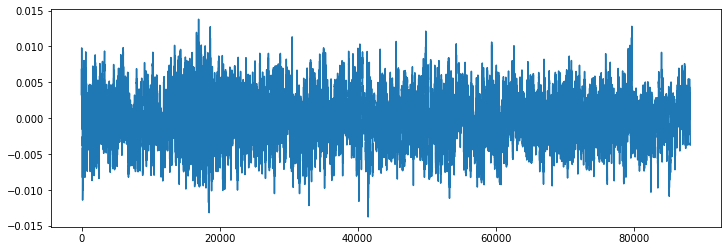

In [3]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [4]:
### Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [5]:
wave_audio

array([[ 194,  100],
       [ 179,  113],
       [ 160,  124],
       ...,
       [-143,  -87],
       [-134,  -91],
       [-110,  -98]], dtype=int16)

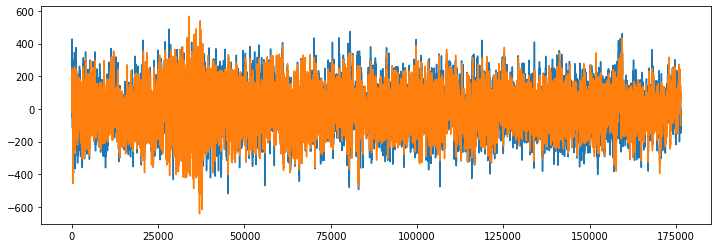

In [6]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio 
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [7]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [8]:
mfccs

array([[-4.45197296e+02, -4.47219299e+02, -4.49755127e+02, ...,
        -4.77412781e+02, -4.74241730e+02, -4.82704987e+02],
       [ 1.12513969e+02,  1.11970390e+02,  1.12244164e+02, ...,
         1.12045395e+02,  1.12248581e+02,  1.05560913e+02],
       [-1.58260937e+01, -2.30021858e+01, -3.12500191e+01, ...,
        -9.15441895e+00, -1.03232269e+01, -7.39410734e+00],
       ...,
       [-7.82766438e+00, -5.03880644e+00, -4.48165131e+00, ...,
        -1.90693259e-01,  4.34143877e+00,  1.00339069e+01],
       [-1.91763473e+00, -8.02736938e-01, -1.20930755e+00, ...,
        -1.23640180e-01,  2.90505886e-02,  9.22017217e-01],
       [-3.88129652e-01,  3.09316814e-01,  6.72155762e+00, ...,
        -2.33736706e+00, -4.25179911e+00, -2.31322789e+00]], dtype=float32)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa

audio_dataset_path='/content/drive/MyDrive/Urbansound8k/UrbanSound8K/audio'
metadata=pd.read_csv('/content/drive/MyDrive/Urbansound8k/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [17]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [18]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [24:26,  2.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8326it [56:27,  2.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8329it [56:28,  2.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [59:07,  2.46it/s]


In [19]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265705,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [20]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [21]:
X.shape

(8732, 40)

In [22]:
### Label Encoding
y=np.array(pd.get_dummies(y))

In [23]:
y.shape

(8732, 10)

In [24]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [25]:
X_train

array([[-1.3183614e+02,  1.1397464e+02, -2.3956861e+01, ...,
         3.3314774e+00, -1.4786111e+00,  2.8736601e+00],
       [-1.4074220e+01,  9.1916939e+01, -8.6787205e+00, ...,
        -3.3844025e+00, -5.2119040e+00, -1.5936139e+00],
       [-4.9532028e+01,  1.5521857e-01, -2.0369110e+01, ...,
         2.0491767e+00, -8.0537486e-01,  2.7793026e+00],
       ...,
       [-4.2699329e+02,  9.2890648e+01,  3.0233369e+00, ...,
         8.6335993e-01,  6.4766800e-01,  7.8490508e-01],
       [-1.4607024e+02,  1.3709459e+02, -3.4298344e+01, ...,
         1.3777871e+00, -1.9530842e+00, -8.9652115e-01],
       [-4.2167450e+02,  2.1169032e+02,  2.6820304e+00, ...,
        -5.1484952e+00, -3.6400859e+00, -1.3321606e+00]], dtype=float32)

In [26]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [27]:
X_train.shape

(6985, 40)

In [28]:
X_test.shape

(1747, 40)

In [29]:
y_train.shape

(6985, 10)

In [30]:
y_test.shape

(1747, 10)

### Model Creation

In [31]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [33]:
### No of classes
num_labels=y.shape[1]

In [34]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [36]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [37]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
219/219 [==============================] - 2s 4ms/step - loss: 10.8998 - accuracy: 0.1231 - val_loss: 2.2831 - val_accuracy: 0.1191

Epoch 00001: val_loss improved from inf to 2.28310, saving model to saved_models/audio_classification.hdf5
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 2.5885 - accuracy: 0.1276 - val_loss: 2.2723 - val_accuracy: 0.1225

Epoch 00002: val_loss improved from 2.28310 to 2.27229, saving model to saved_models/audio_classification.hdf5
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 2.3430 - accuracy: 0.1384 - val_loss: 2.2348 - val_accuracy: 0.1534

Epoch 00003: val_loss improved from 2.27229 to 2.23475, saving model to saved_models/audio_classification.hdf5
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 2.2426 - accuracy: 0.1649 - val_loss: 2.1697 - val_accuracy: 0.1855

Epoch 00004: val_loss improved from 2.23475 to 2.16971, saving model to saved_models/audio_cla

In [38]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7738981246948242


In [39]:
filename="/content/dog"
prediction_feature=features_extractor(filename)
prediction_feature=prediction_feature.reshape(1,-1)
model.predict_classes(prediction_feature)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1])